# Giesekus Stress Relaxation: Faster-than-Maxwell Decay

## Protocol Overview: Stress Relaxation After Step Strain

In a stress relaxation test, we apply a constant shear rate γ̇ until steady state, then suddenly stop (γ̇ → 0) and measure the stress decay σ(t). The **relaxation modulus** G(t) = σ(t)/γ₀ (for small step strain γ₀) characterizes the material's time-dependent stress release.

**Key physics for Giesekus:**  
For a Maxwell fluid (linear viscoelastic):
$$
\sigma(t) = \sigma_0 \exp(-t/\lambda)
$$

For the Giesekus model, the relaxation is **faster than exponential** due to the α·τ·τ term:

$$
\frac{d\boldsymbol{\tau}}{dt} = -\frac{1}{\lambda}\left(\boldsymbol{\tau} + \frac{\alpha}{\eta_p}\boldsymbol{\tau}\cdot\boldsymbol{\tau}\right)
$$

The quadratic stress term provides **additional dissipation** that accelerates decay when stress is high:
- **α = 0** (UCM): Pure exponential relaxation
- **α > 0** (Giesekus): Faster-than-exponential decay, especially at short times
- Higher α → faster initial decay → more rapid stress release

**Semi-log diagnostic:** On a semi-log plot (log σ vs t), Maxwell gives a straight line. Giesekus with α > 0 shows **downward curvature** (faster decay).

## Learning Objectives

1. Fit the Giesekus model to real polymer stress relaxation data
2. Understand how the α·τ·τ term accelerates stress decay
3. Compare Giesekus relaxation to single-exponential Maxwell
4. Observe the effect of α on relaxation shape (semi-log curvature)
5. Extract relaxation modulus G(t) from the data

## Prerequisites

- Basic RheoJAX usage (basic/01-maxwell-fitting.ipynb)
- Bayesian inference fundamentals (bayesian/01-bayesian-basics.ipynb)

## Estimated Runtime

- **Fast demo** (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- **Full run** (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import gc
import json
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.giesekus import GiesekusSingleMode

# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarning (jax.core.mapped_aval/unmapped_aval deprecated in JAX 0.8+)
warnings.filterwarnings("ignore", message=".*jax\\.core\\.(mapped|unmapped)_aval.*", category=DeprecationWarning)

# CI/demo toggle: True = fast (fewer samples/points), False = production
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: Stress Relaxation in Giesekus

### The Experiment

In a stress relaxation test, we apply a constant shear rate γ̇ until steady state, then suddenly stop (γ̇ → 0) and measure the stress decay σ(t).

### Maxwell Relaxation

For a Maxwell fluid:
$$
\sigma(t) = \sigma_0 \exp(-t/\lambda)
$$

where σ₀ is the stress at t = 0 (when shear stops).

### Giesekus Relaxation

For the Giesekus model, the relaxation is **faster than exponential** due to the quadratic τ·τ term. The stress decays as:

$$
\frac{d\boldsymbol{\tau}}{dt} = -\frac{1}{\lambda}\left(\boldsymbol{\tau} + \frac{\alpha}{\eta_p}\boldsymbol{\tau}\cdot\boldsymbol{\tau}\right)
$$

The τ·τ term provides **additional dissipation** that accelerates decay.

### Key Features

| Model | Relaxation Shape | Short Time | Long Time |
|-------|-----------------|------------|------------|
| Maxwell | Exponential | σ ~ σ₀ | σ ~ exp(-t/λ) |
| Giesekus (α > 0) | Faster-than-exponential | Similar to Maxwell | Faster decay |
| Giesekus (α = 0) | Maxwell | (UCM limit) | |

### Relaxation Modulus

The relaxation modulus is defined as:
$$
G(t) = \frac{\sigma(t)}{\gamma_0}
$$

where γ₀ is a small applied strain.

## 3. Load Data

We use polystyrene stress relaxation data at T = 145°C.

In [3]:
# Load polymer relaxation data
data_path = os.path.join("..", "data", "relaxation", "polymers", "stressrelaxation_ps145_data.csv")

# Tab-separated with header
raw = np.loadtxt(data_path, delimiter="\t", skiprows=1)
time_data = raw[:, 0]  # Time (s)
G_data = raw[:, 1]  # Relaxation modulus (Pa)

print(f"Loaded {len(time_data)} data points")
print(f"Time range: [{time_data.min():.3f}, {time_data.max():.1f}] s")
print(f"G(t) range: [{G_data.min():.2f}, {G_data.max():.2f}] Pa")

Loaded 1799 data points
Time range: [0.201, 1803.0] s
G(t) range: [1361.90, 143000.00] Pa


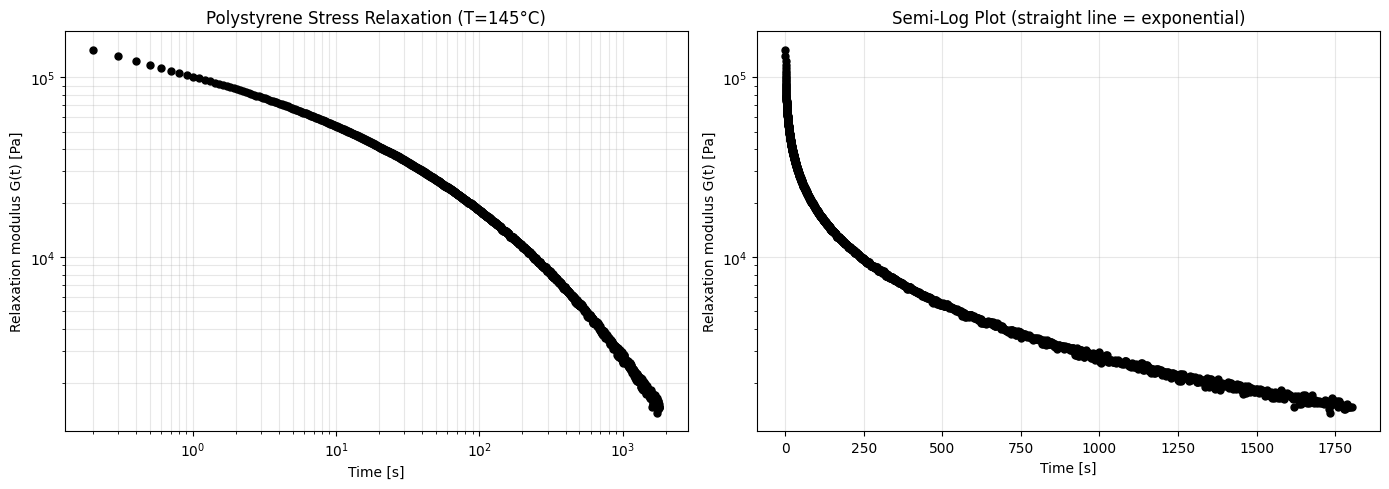

In [4]:
# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Log-log scale
ax1.loglog(time_data, G_data, "ko", markersize=5)
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Relaxation modulus G(t) [Pa]")
ax1.set_title("Polystyrene Stress Relaxation (T=145°C)")
ax1.grid(True, alpha=0.3, which="both")

# Semi-log (to check for exponential)
ax2.semilogy(time_data, G_data, "ko", markersize=5)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Relaxation modulus G(t) [Pa]")
ax2.set_title("Semi-Log Plot (straight line = exponential)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

In [5]:
# Create and fit Giesekus model
model = GiesekusSingleMode()

# For relaxation, we need to specify the pre-shear rate
gamma_dot_preshear = 1.0  # 1/s (assumed)

# Subsample for fitting: ODE-based relaxation requires diffrax to solve an
# adaptive ODE at each save point. Fewer points + shorter range = less memory
# from XLA compiled modules and reverse-mode AD intermediates.
n_fit_pts = 50 if FAST_MODE else 150
t_fit_max = 500.0 if FAST_MODE else time_data[-1]  # 3 decades is ample for single-mode
mask_fit = time_data <= t_fit_max
time_trimmed_fit = time_data[mask_fit]
G_trimmed_fit = G_data[mask_fit]
idx_fit = np.unique(np.round(np.logspace(0, np.log10(len(time_trimmed_fit) - 1), n_fit_pts)).astype(int))
time_fit = time_trimmed_fit[idx_fit]
G_fit = G_trimmed_fit[idx_fit]
print(f"NLSQ data: {len(time_data)} -> {len(idx_fit)} points, t=[{time_fit[0]:.2f}, {time_fit[-1]:.1f}]s")

t0 = time.time()
model.fit(time_fit, G_fit, test_mode="relaxation", gamma_dot=gamma_dot_preshear, method='scipy')
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
param_names = ["eta_p", "lambda_1", "alpha", "eta_s"]
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

# Derived quantities
eta_p = model.parameters.get_value("eta_p")
eta_s = model.parameters.get_value("eta_s")
lambda_1 = model.parameters.get_value("lambda_1")
alpha = model.parameters.get_value("alpha")

G_0 = eta_p / lambda_1

print(f"\nDerived quantities:")
print(f"  G_0 = eta_p/lambda = {G_0:.2f} Pa")
print(f"  Relaxation time lambda = {lambda_1:.3f} s")

# Free NLSQ JIT caches to reduce memory baseline for subsequent ODE sections
gc.collect()
jax.clear_caches()

NLSQ data: 1799 -> 43 points, t=[0.30, 499.3]s


NLSQ fit time: 98.63 s

Fitted parameters:
  eta_p      = 395.4
  lambda_1   = 50.72
  alpha      = 0.2886
  eta_s      = 20.67

Derived quantities:
  G_0 = eta_p/lambda = 7.80 Pa
  Relaxation time lambda = 50.721 s


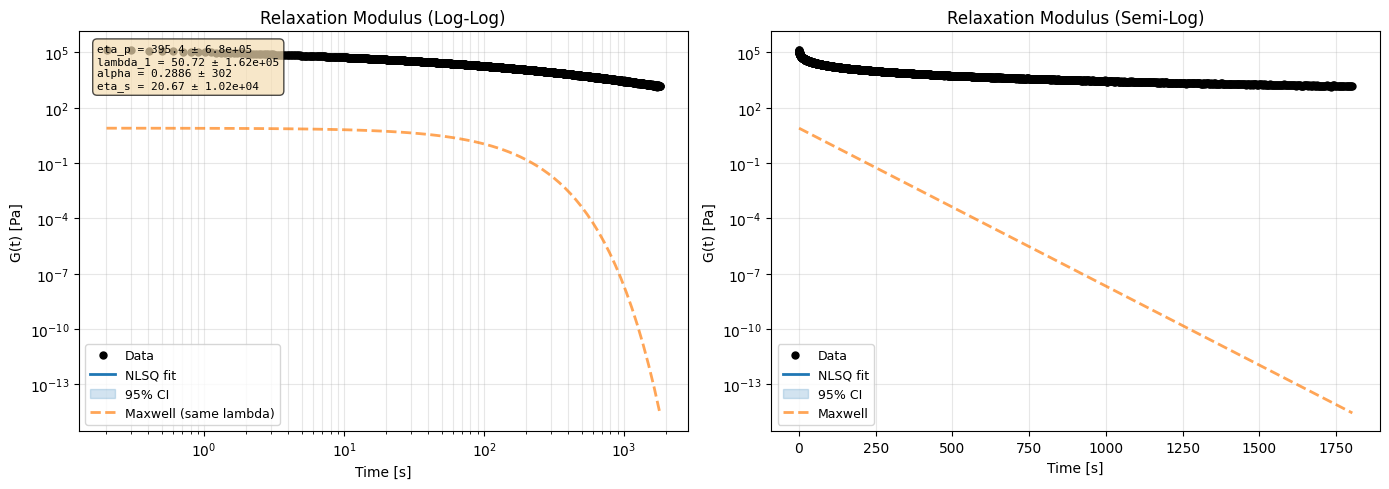

In [6]:
# Plot NLSQ fit with uncertainty band + Maxwell comparison
n_plot = 100 if FAST_MODE else 200
time_fine = np.logspace(
    np.log10(time_data.min()),
    np.log10(time_data.max()),
    n_plot,
)

# Maxwell comparison
G_maxwell = G_0 * np.exp(-time_fine / lambda_1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Log-log with uncertainty band
plot_nlsq_fit(
    time_data, G_data, model, test_mode="relaxation",
    param_names=param_names,
    x_pred=time_fine,
    log_scale=True,
    xlabel="Time [s]", ylabel="G(t) [Pa]",
    title="Relaxation Modulus (Log-Log)",
    ax=ax1,
    gamma_dot=gamma_dot_preshear,
)
ax1.loglog(time_fine, G_maxwell, "--", lw=2, color="C1", alpha=0.7, label="Maxwell (same lambda)")
ax1.legend(fontsize=9)

# Semi-log
plot_nlsq_fit(
    time_data, G_data, model, test_mode="relaxation",
    param_names=param_names,
    x_pred=time_fine,
    log_scale=False,
    xlabel="Time [s]", ylabel="G(t) [Pa]",
    title="Relaxation Modulus (Semi-Log)",
    show_annotation=False,
    ax=ax2,
    gamma_dot=gamma_dot_preshear,
)
ax2.semilogy(time_fine, G_maxwell, "--", lw=2, color="C1", alpha=0.7, label="Maxwell")
ax2.set_yscale("log")
ax2.legend(fontsize=9)

plt.tight_layout()
display(fig)
plt.close(fig)

# Free prediction arrays and JIT caches before parametric study
del G_maxwell, time_fine
gc.collect()
jax.clear_caches()

## 5. Effect of α on Relaxation

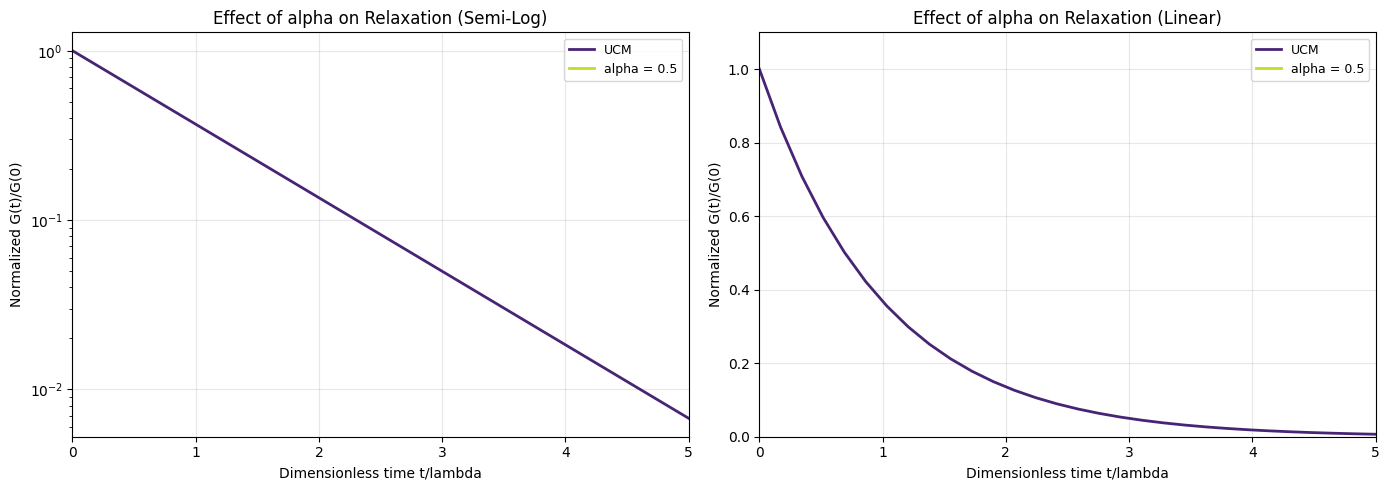

Key observation: Higher alpha -> faster relaxation
The tau*tau term provides additional dissipation.


In [7]:
# Compare different alpha values
if FAST_MODE:
    alpha_values = [0.0, 0.5]
    n_sim_pts = 30
else:
    alpha_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    n_sim_pts = 200

colors = plt.cm.viridis(np.linspace(0.1, 0.9, len(alpha_values)))

# Use fitted parameters but vary alpha
time_sim = np.linspace(0.01, 5 * lambda_1, n_sim_pts)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for i, alpha_i in enumerate(alpha_values):
    model_i = GiesekusSingleMode()
    model_i.parameters.set_value("eta_p", eta_p)
    model_i.parameters.set_value("lambda_1", lambda_1)
    model_i.parameters.set_value("alpha", alpha_i)
    model_i.parameters.set_value("eta_s", eta_s)
    
    G_i = np.array(model_i.simulate_relaxation(time_sim, gamma_dot_preshear=gamma_dot_preshear))
    G_i_norm = G_i / G_i[0]  # Normalize
    
    label = "UCM" if alpha_i == 0 else f"alpha = {alpha_i}"
    
    ax1.semilogy(time_sim / lambda_1, G_i_norm, "-", lw=2, color=colors[i], label=label)
    ax2.plot(time_sim / lambda_1, G_i_norm, "-", lw=2, color=colors[i], label=label)

ax1.set_xlabel("Dimensionless time t/lambda")
ax1.set_ylabel("Normalized G(t)/G(0)")
ax1.set_title("Effect of alpha on Relaxation (Semi-Log)")
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 5)

ax2.set_xlabel("Dimensionless time t/lambda")
ax2.set_ylabel("Normalized G(t)/G(0)")
ax2.set_title("Effect of alpha on Relaxation (Linear)")
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 5)
ax2.set_ylim(0, 1.1)

plt.tight_layout()
display(fig)
plt.close(fig)

print("Key observation: Higher alpha -> faster relaxation")
print("The tau*tau term provides additional dissipation.")

# Free ODE compilation memory before Bayesian
del model_i
gc.collect()
jax.clear_caches()

## 6. Bayesian Inference

In [8]:
# Bayesian inference with NLSQ warm-start
initial_values = {
    name: model.parameters.get_value(name)
    for name in param_names
}
print("Warm-start values:")
for k, v in initial_values.items():
    print(f"  {k}: {v:.4g}")

# FAST_MODE: reduced Bayesian due to high memory cost of ODE-based NUTS.
# Each NUTS iteration solves a 4-component ODE via diffrax, and reverse-mode AD
# stores all internal adaptive steps. For production runs, use a machine with
# more memory or run the Bayesian section separately.
if FAST_MODE:
    NUM_WARMUP = 25
    NUM_SAMPLES = 20
    NUM_CHAINS = 1
    n_bayes_pts = 15
    t_cutoff = 50.0
else:
    NUM_WARMUP = 250
    NUM_SAMPLES = 2000
    NUM_CHAINS = 4
    n_bayes_pts = 60
    t_cutoff = 500.0

# Trim + subsample for Bayesian. Limiting the time range is critical because
# diffrax's PID controller takes many internal steps over long integrations,
# and each step is stored for gradient computation.
mask = time_data <= t_cutoff
time_trimmed = time_data[mask]
G_trimmed = G_data[mask]

n_trimmed = len(time_trimmed)
if n_trimmed > n_bayes_pts:
    idx_b = np.unique(np.round(np.logspace(0, np.log10(n_trimmed - 1), n_bayes_pts)).astype(int))
    time_bayes = time_trimmed[idx_b]
    G_bayes = G_trimmed[idx_b]
else:
    time_bayes = time_trimmed
    G_bayes = G_trimmed
print(f"\nBayesian data: {len(time_data)} -> {len(time_bayes)} pts, t=[{time_bayes[0]:.2f}, {time_bayes[-1]:.1f}]s")

gc.collect()
jax.clear_caches()

t0 = time.time()
result = model.fit_bayesian(
    time_bayes,
    G_bayes,
    test_mode="relaxation",
    gamma_dot=gamma_dot_preshear,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=200,
    target_accept_prob=0.97,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values:
  eta_p: 395.4
  lambda_1: 50.72
  alpha: 0.2886
  eta_s: 20.67

Bayesian data: 1799 -> 14 pts, t=[0.30, 49.9]s


  0%|          | 0/45 [00:00<?, ?it/s]

warmup:   2%|▏         | 1/45 [00:06<04:31,  6.17s/it, 1 steps of size 1.71e+00. acc. prob=0.00]

warmup:   4%|▍         | 2/45 [00:07<02:20,  3.27s/it, 1 steps of size 1.03e-01. acc. prob=0.00]

warmup:  42%|████▏     | 19/45 [00:07<00:05,  4.52it/s, 255 steps of size 6.68e-03. acc. prob=0.84]

sample:  58%|█████▊    | 26/45 [00:09<00:04,  4.42it/s, 23 steps of size 1.20e-01. acc. prob=1.00] 

sample:  67%|██████▋   | 30/45 [00:12<00:05,  2.90it/s, 6 steps of size 1.20e-01. acc. prob=0.91] 

sample:  73%|███████▎  | 33/45 [00:13<00:04,  2.76it/s, 15 steps of size 1.20e-01. acc. prob=0.94]

sample:  91%|█████████ | 41/45 [00:13<00:00,  4.67it/s, 127 steps of size 1.20e-01. acc. prob=0.95]

sample: 100%|██████████| 45/45 [00:13<00:00,  3.29it/s, 95 steps of size 1.20e-01. acc. prob=0.94] 


Bayesian inference time: 24.0 s


In [9]:
# Convergence diagnostics
diag = result.diagnostics

print("Convergence Diagnostics")
print("=" * 55)
print(f"{'Parameter':>12s}  {'R-hat':>8s}  {'ESS':>8s}  {'Status':>8s}")
print("-" * 55)

for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    status = "PASS" if (r_hat < 1.05 and ess > 100) else "CHECK"
    print(f"{p:>12s}  {r_hat:8.4f}  {ess:8.0f}  {status:>8s}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
   Parameter     R-hat       ESS    Status
-------------------------------------------------------
       eta_p    1.5140         5     CHECK
    lambda_1    0.9571        15     CHECK
       alpha    0.9599        19     CHECK
       eta_s    0.9726         9     CHECK

Divergences: 4


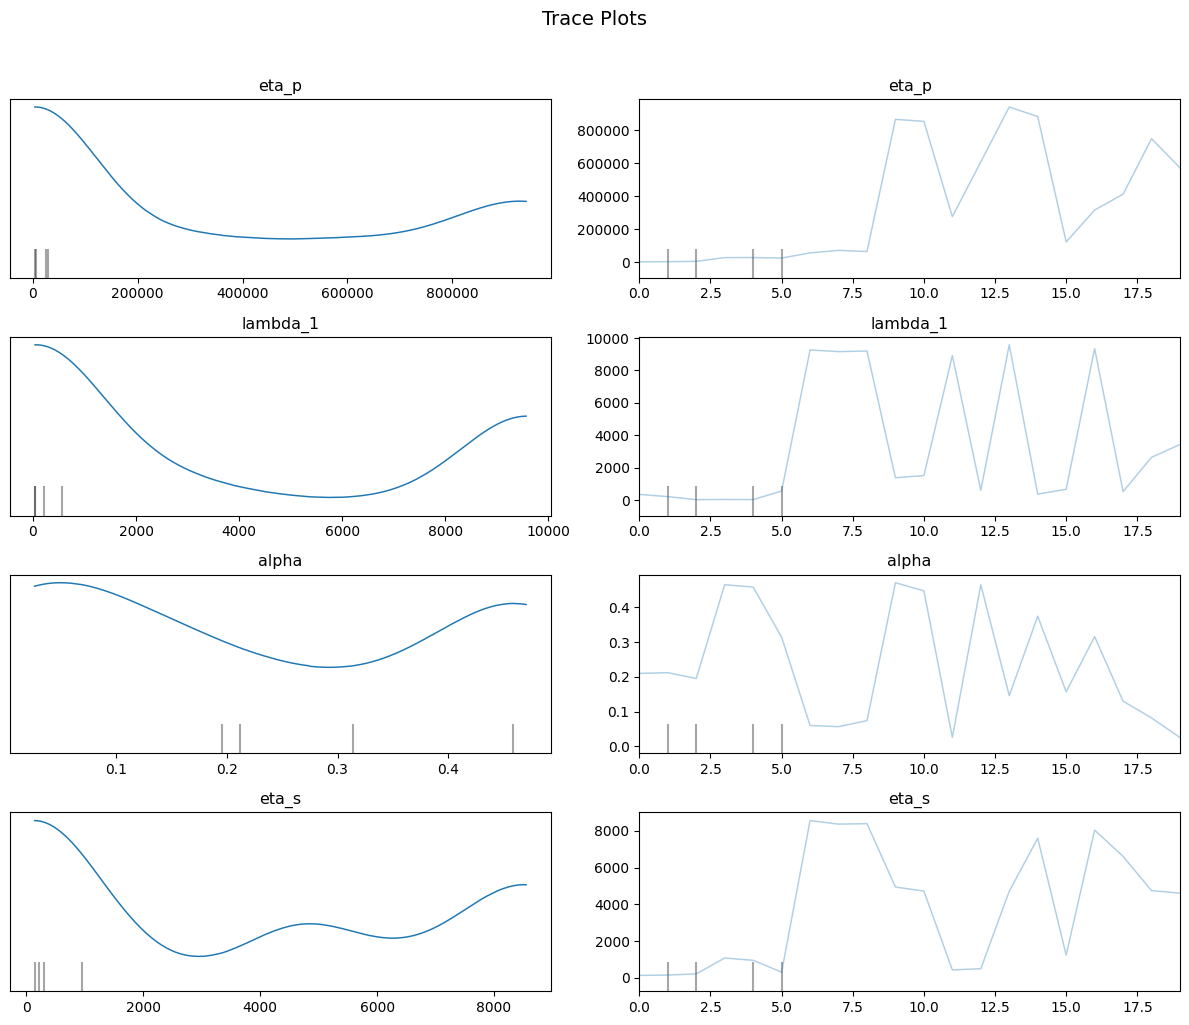

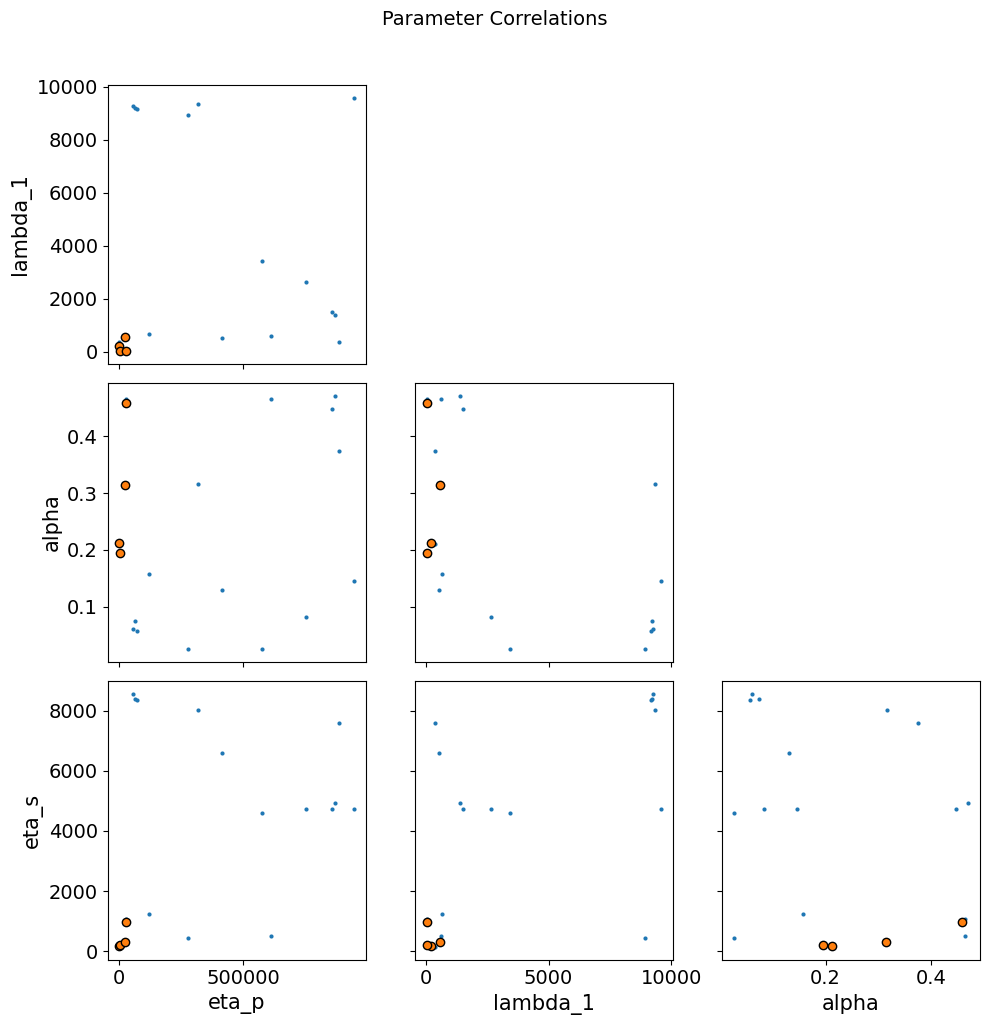

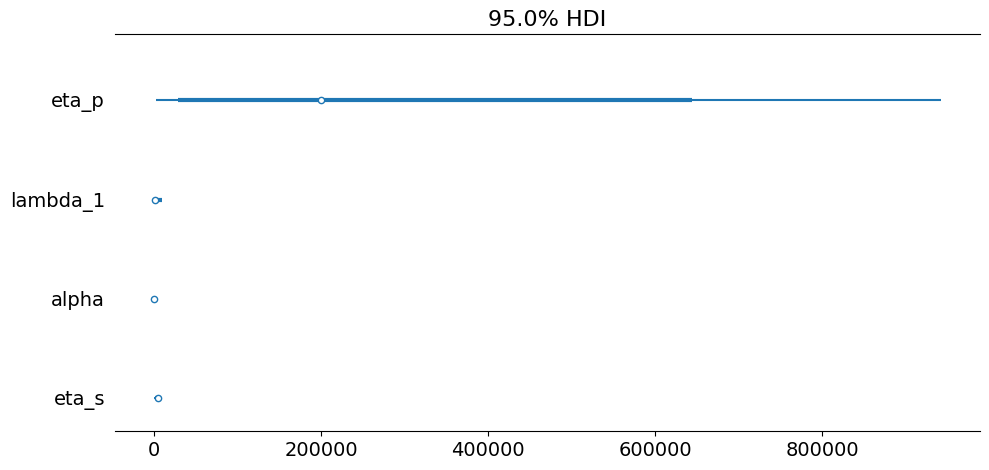

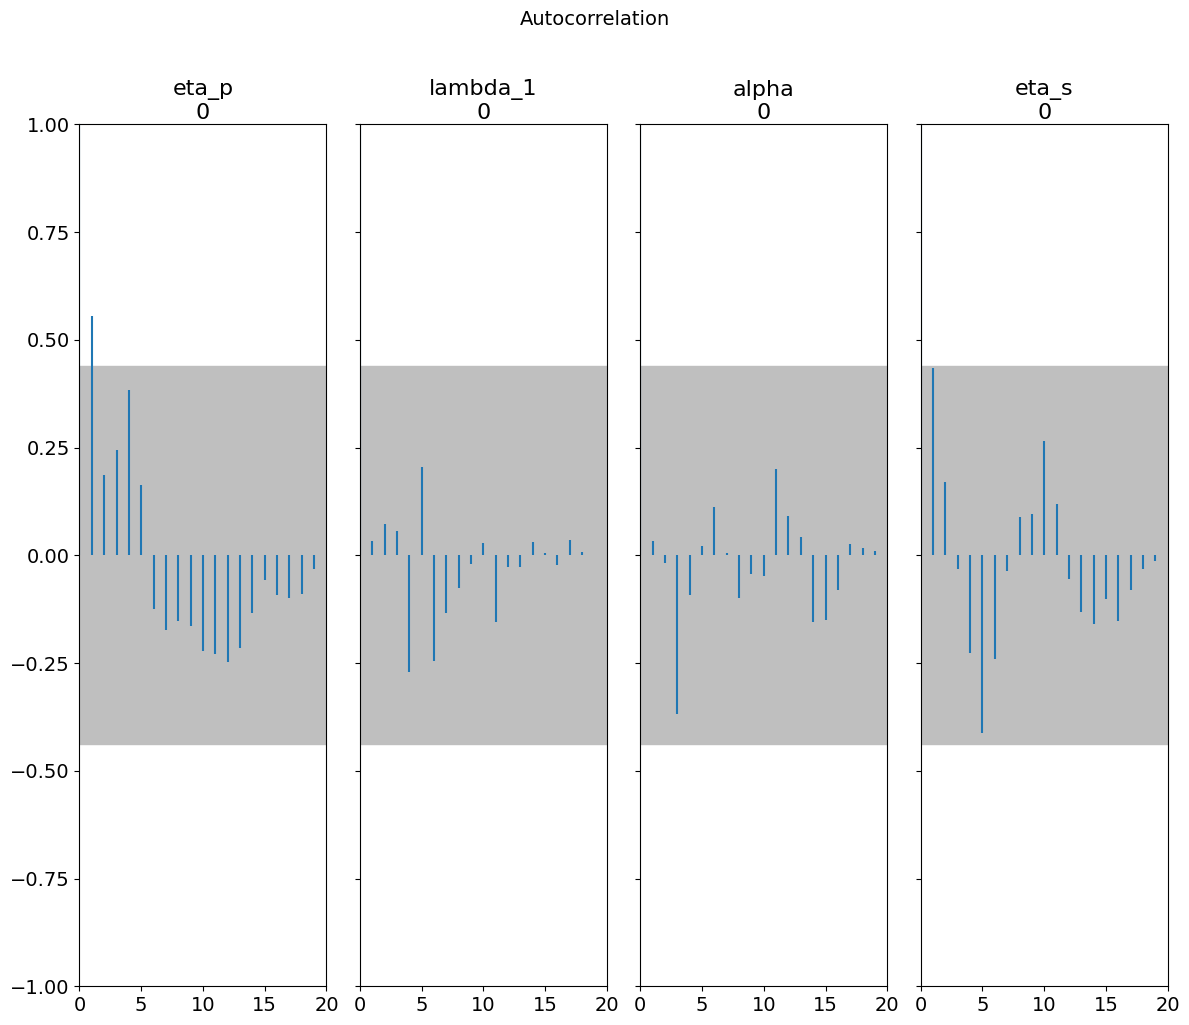

In [10]:
# Full ArviZ diagnostics: trace, pair, forest, energy, autocorr, rank
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

## 7. Parameter Summary

In [11]:
# NLSQ vs Bayesian comparison
posterior = result.posterior_samples

print("Parameter Comparison: NLSQ vs Bayesian")
print("=" * 70)
print(f"{'Param':>12s}  {'NLSQ':>12s}  {'Bayes median':>14s}  {'95% CI':>26s}")
print("-" * 70)

for name in param_names:
    nlsq_val = initial_values[name]
    bayes_samples = posterior[name]
    median = float(np.median(bayes_samples))
    lo = float(np.percentile(bayes_samples, 2.5))
    hi = float(np.percentile(bayes_samples, 97.5))
    print(f"{name:>12s}  {nlsq_val:12.4g}  {median:14.4g}  [{lo:.4g}, {hi:.4g}]")

Parameter Comparison: NLSQ vs Bayesian
       Param          NLSQ    Bayes median                      95% CI
----------------------------------------------------------------------
       eta_p         395.4       1.997e+05  [2900, 9.146e+05]
    lambda_1         50.72            1027  [33.57, 9471]
       alpha        0.2886          0.2028  [0.0259, 0.4681]
       eta_s         20.67            4664  [143, 8478]


## 8. Save Results

In [12]:
# Save results
output_dir = os.path.join("..", "outputs", "giesekus", "relaxation")
os.makedirs(output_dir, exist_ok=True)

# Save NLSQ point estimates
nlsq_params = initial_values.copy()
with open(os.path.join(output_dir, "nlsq_params_relaxation.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save posterior samples
posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_relaxation.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")

Results saved to ../outputs/giesekus/relaxation/


## Key Takeaways

1. **Giesekus relaxation is faster than Maxwell** due to the quadratic α·τ·τ term. The additional dissipation from anisotropic drag accelerates stress decay, especially at early times.

2. **α controls the deviation from exponential**. Higher α → faster relaxation → more pronounced curvature in semi-log plots. At α = 0 (UCM), Giesekus reduces to single-exponential Maxwell.

3. **Semi-log plot diagnostic**: A straight line indicates exponential relaxation (Maxwell). Downward curvature (concave down) indicates non-exponential behavior — signature of Giesekus with α > 0.

4. **Multi-mode extension**: Real polymers often show broad relaxation spectra requiring multiple modes. Each mode contributes exponentially, but the α·τ·τ term in each mode accelerates its decay.

5. **Relaxation modulus** G(t) is related to complex modulus G*(ω) via Fourier transform, connecting time-domain and frequency-domain measurements.

### Physical Interpretation

- **Short times** (t ≪ λ): Stress is high → α·τ·τ dissipation is strong → rapid initial decay
- **Long times** (t ≫ λ): Stress is low → α·τ·τ term negligible → approaches Maxwell (exponential tail)

The **faster-than-exponential decay** at short times is a direct consequence of stress-dependent dissipation via anisotropic molecular mobility.

### Experimental Considerations

| Challenge | Mitigation |
|-----------|----------|
| Instrument inertia | Use torque rheometry with fast data acquisition |
| Step strain uniformity | Pre-shear to equilibrate, then impose step |
| Sample aging | Control rest time, temperature |
| Data at t → 0 | Instrument response time limits |

### Applications

- **Polymer processing**: Estimate stress decay during cooling/solidification
- **Adhesives**: Predict bond strength relaxation over time
- **Coatings**: Sagging behavior (stress relaxation under gravity)
- **Biomedical**: Tissue mechanics, drug release from gels

### Next Steps

- **NB 07**: LAOS (nonlinear oscillatory response, Lissajous distortion, Fourier harmonics)

## Further Reading

**RheoJAX Documentation:**
- [Giesekus Model Reference](../../docs/source/models/giesekus/giesekus.rst) — Relaxation equations (§ Protocol-Specific Equations)
- [Giesekus Index](../../docs/source/models/giesekus/index.rst) — All 6 supported protocols

**Key References:**
1. Giesekus, H. (1982). "A simple constitutive equation for polymer fluids based on the concept of deformation-dependent tensorial mobility." *J. Non-Newtonian Fluid Mech.*, 11, 69-109.

2. Bird, R.B., Armstrong, R.C., & Hassager, O. (1987). *Dynamics of Polymeric Liquids, Vol. 1.* Wiley. Chapter 4.

3. Larson, R.G. (1988). *Constitutive Equations for Polymer Melts and Solutions.* Butterworths. Chapter 4.